<a id='top'></a>
# Indeed.com web scraper

This script implements the following functions:

* takes as input [URL](https://ca.indeed.com/jobs?q=data+scientist&l=Canada) to the first page of search results for a Data Scientist from [ca.indeed.com](https://ca.indeed.com/?r=us)
* generates a list containing URLs of all search pages showing results for a Data Scientist
* scrapes the HTML of every individual job posting
* parses the HTML to extract information with job details and skills mentioned in each job posting
* summarizes and displays results
* saves results to a .csv file

## Preparations

### Import libraries

In [1]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
from IPython.display import HTML

### Define functions

#### Common part of the link is extracted from the following page element:

<div class="pagination" onmousedown="pclk(event);">Results&nbsp;Page:&nbsp;&nbsp;<b>1</b>&nbsp;&nbsp;<a onmousedown="addPPUrlParam &amp;&amp; addPPUrlParam(this);" href="/jobs?q=data+scientist&amp;l=Canada&amp;start=10" data-pp="AAoAAAFoZqgkkAAAAAFXSCBYAQEBCALrXYJuTQSs_jR2-csJgC4tCczsklNYN72HmP3dIjsagQqhcf-jmxJlFGCUC5ge_FHPKA"><span class="pn">2</span></a>&nbsp;&nbsp;<a onmousedown="addPPUrlParam &amp;&amp; addPPUrlParam(this);" href="/jobs?q=data+scientist&amp;l=Canada&amp;start=20" data-pp="ABQAAAFoZqgkkAAAAAFXSCBYAQIBCBYHAK9oIvlQ7ma5O7RQ10OywgMDrqdo7hgb38E6MjUSW-9JsWrwNuXJhmp_mXrc-SBKc9VfGQ_j31bifuiAW_IU96mh"><span class="pn">3</span></a>&nbsp;&nbsp;<a onmousedown="addPPUrlParam &amp;&amp; addPPUrlParam(this);" href="/jobs?q=data+scientist&amp;l=Canada&amp;start=30" data-pp="AB4AAAFoZqgkkAAAAAFXSCBYAQIBCBILNhrPEpk28Saslvqtc58RJ17f7BLY31zKPkhZB5B4nXYeT-D0-XdRInCcZcRk7nI_wgYZue01ZMnMx1M-iV35qwdPLndLhDsnH4EpwRY3H5IJ"><span class="pn">4</span></a>&nbsp;&nbsp;<a onmousedown="addPPUrlParam &amp;&amp; addPPUrlParam(this);" href="/jobs?q=data+scientist&amp;l=Canada&amp;start=40" data-pp="ACgAAAFoZqgkkAAAAAFXSCBYAQMBCBIMIAcHCtUrvKV0P-DHbL0AnBbTSKXxCTvXd0siyDQR4qiP4kePlDlNP2tvXED40V5bBIZWx_1qDo0RP6vsOfLuyN1MZW9SsQy02dvtEPrFu5TxVkJ0EdhTLqjnVmKJumGF"><span class="pn">5</span></a>&nbsp;&nbsp; <a onmousedown="addPPUrlParam &amp;&amp; addPPUrlParam(this);" href="/jobs?q=data+scientist&amp;l=Canada&amp;start=10" data-pp="AAoAAAFoZqgkkAAAAAFXSCBYAQEBCALrXYJuTQSs_jR2-csJgC4tCczsklNYN72HmP3dIjsagQqhcf-jmxJlFGCUC5ge_FHPKA"><span class="pn"><span class="np">Next&nbsp;»</span></span></a></div>

HTML code of the element:

<div class="pagination" onmousedown="pclk(event);">Results&nbsp;Page:&nbsp;&nbsp;<b>1</b>&nbsp;&nbsp;<a onmousedown="addPPUrlParam &amp;&amp; addPPUrlParam(this);" href="/jobs?q=data+scientist&amp;l=Canada&amp;start=10" data-pp="AAoAAAFoZqgkkAAAAAFXSCBYAQEBCALrXYJuTQSs_jR2-csJgC4tCczsklNYN72HmP3dIjsagQqhcf-jmxJlFGCUC5ge_FHPKA"><span class="pn">2</span></a>&nbsp;&nbsp;<a onmousedown="addPPUrlParam &amp;&amp; addPPUrlParam(this);" href="/jobs?q=data+scientist&amp;l=Canada&amp;start=20" data-pp="ABQAAAFoZqgkkAAAAAFXSCBYAQIBCBYHAK9oIvlQ7ma5O7RQ10OywgMDrqdo7hgb38E6MjUSW-9JsWrwNuXJhmp_mXrc-SBKc9VfGQ_j31bifuiAW_IU96mh"><span class="pn">3</span></a>&nbsp;&nbsp;<a onmousedown="addPPUrlParam &amp;&amp; addPPUrlParam(this);" href="/jobs?q=data+scientist&amp;l=Canada&amp;start=30" data-pp="AB4AAAFoZqgkkAAAAAFXSCBYAQIBCBILNhrPEpk28Saslvqtc58RJ17f7BLY31zKPkhZB5B4nXYeT-D0-XdRInCcZcRk7nI_wgYZue01ZMnMx1M-iV35qwdPLndLhDsnH4EpwRY3H5IJ"><span class="pn">4</span></a>&nbsp;&nbsp;<a onmousedown="addPPUrlParam &amp;&amp; addPPUrlParam(this);" href="/jobs?q=data+scientist&amp;l=Canada&amp;start=40" data-pp="ACgAAAFoZqgkkAAAAAFXSCBYAQMBCBIMIAcHCtUrvKV0P-DHbL0AnBbTSKXxCTvXd0siyDQR4qiP4kePlDlNP2tvXED40V5bBIZWx_1qDo0RP6vsOfLuyN1MZW9SsQy02dvtEPrFu5TxVkJ0EdhTLqjnVmKJumGF"><span class="pn">5</span></a>&nbsp;&nbsp; <a onmousedown="addPPUrlParam &amp;&amp; addPPUrlParam(this);" href="/jobs?q=data+scientist&amp;l=Canada&amp;start=10" data-pp="AAoAAAFoZqgkkAAAAAFXSCBYAQEBCALrXYJuTQSs_jR2-csJgC4tCczsklNYN72HmP3dIjsagQqhcf-jmxJlFGCUC5ge_FHPKA"><span class="pn"><span class="np">Next&nbsp;»</span></span></a></div>

#### Total number of results is extracted from the following page element:

<div id="searchCount">
        Page 1 of 1,031 jobs</div>

HTML code of the element:

<div id="searchCount">
        Page 1 of 1,031 jobs</div>

#### `get_all_search_pages`

In [2]:
def get_all_search_pages(url, max_postings=0):
    """
    a function to generate links to all subsequent search results pages

    Input arguments: 'url'   -- str  -- starting page url, a page from search results
          'max_postings'   -- int  -- option to limit number of results returned
                                        (0 means no limit, return full results)

    Returns: 'list_of_all_urls' -- list -- list of all subsequent URLs
             'total_results'    -- int  -- total number of jobs postings found
    """

    # get the HTML of the first search results page
    r = requests.get(url)
    content = r.text

    # make a soup out of the first page of search results
    soup_1 = BeautifulSoup(content, 'lxml')

    # extract the number of search results
    num_results_str = soup_1.find('div', {'id': 'searchCount'}).text
    # parse the string and extract the total number (4th element), replace comma with an empty space, convert to int
    total_results = int(num_results_str.split()[3].replace(',', ''))

    # add the common part between all search pages
    next_pages_links = "https://www.indeed.ca" + \
                       soup_1.find('div', {'class': 'pagination'}) \
                       .find('a').get('href')[:-2]

    print(next_pages_links)

    # create empty list to store URLs of all search results pages
    list_of_all_urls = list()

    # add the first page to the 'list_of_all_urls'
    list_of_all_urls.append(next_pages_links)

    if max_postings:
        # generate subsequent search results links (max postings -- parameter 'max_postings')
        for start_position in range(20, max_postings, 20):
            list_of_all_urls.append(next_pages_links + str(start_position))
    else:
        # generate subsequent search results links (max postings -- total search results)
        for start_position in range(20, total_results, 20):
            list_of_all_urls.append(next_pages_links + str(start_position))

    print("Search returned a total of {0} results.".format(total_results))
    print("A list with {0} links to subsequent search results pages was returned."
          .format(len(list_of_all_urls)))
    if max_postings:
        print("Returned list contains links to the first {0} job postings, as per the provided 'max_postings."
              .format(max_postings))

    return list_of_all_urls, total_results


#### `scrape_job_posts`

In [3]:
def scrape_job_posts(list_of_all_urls, time_delay=0.5):
    """
    a function to scrape individual job postings
    (via another function 'scrape_job_info')

    gets HTML of each search page from the list
    generated by the function 'get_all_search_pages',
    parses links to individual job postings
    from search results pages, and then scrapes those
    job postings

    Input arguments: list_of_all_urls   -- list  -- list containing URLs of all pages with job search results
                     time_delay           -- float -- delay used between requests to indeed server
    """
    # dictionary used to store results of scraping
    scraping_results_dict = dict()
    num_page = 0
    for search_page_url in list_of_all_urls:

        # get the HTML of the search results page
        page = requests.get(search_page_url)
        content = page.text
        # make a soup out of the HTML
        soup = BeautifulSoup(content, 'lxml')

        # find all <div> tags containing each job posting links and feed them to the function 'scrape_job_info'
        links = soup.find_all('div', {'class': 'jobsearch-SerpJobCard row result'})
        links += soup.find_all('div', {'class': 'jobsearch-SerpJobCard row sjlast result'})
        links += soup.find_all('div', {'class': 'jobsearch-SerpJobCard lastRow row result'})

        num_scraped = 0

        for job_link in links:
            # extract the individual job posting link from a <div> tag
            full_job_link = "https://www.indeed.ca" + job_link.find('a')['href']

            # get the HTML code from the job posting page and save it as text to 'scraping_results_dict'
            # link to the job posting is used as a key and HTML code of the job posting as a value
            job_html = requests.get(full_job_link)
            scraping_results_dict[full_job_link] = job_html.text
            num_scraped += 1

            # sleep for 0.5 second, to avoid too frequent requests to the indeed.ca server
            time.sleep(time_delay)
        num_page += 1
        print("Scraped {0} individual job postings from page {1} of {2}."
              .format(num_scraped, num_page, len(list_of_all_urls)))

    print("--- {0} job postings have been scraped and saved to 'scraping_results_dict'."
          .format(len(scraping_results_dict)))
    return scraping_results_dict


#### `parse_skills`

In [4]:
def parse_skills(scraping_results_dict, skills_keywords_dict):
    """
    function to parse job info from previously scraped job pages
    extracts info from HTML of each job page, saves it to the dictionary 'results_dict'

    Input arguments: scraping_results_dict -- dictionary -- contains 'link'--'HTML code'
                                                            pairs of job postings
                     skills_keywords_dict  -- dictionary -- contains skill categories and
                                                            corresponding lists of keywords
    """
    # dictionary that is used to store scraping results
    # keys will be job links and values will become job posting features
    results_dict = dict()
    for link, job_html_text in scraping_results_dict.items():

        # make a soup out of a job posting HTML code
        soup_job = BeautifulSoup(job_html_text, 'lxml')

        # create a new sub-dictionary in the 'results_dict' with the job link as key
        results_dict[link] = {}

        # extract job title from the job page
        try:
            results_dict[link]['job_title'] = soup_job.find_all('h3',
                                                                {'class':
                                            'icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title'})[0].text
        except IndexError:
            results_dict[link]['job_title'] = 'Not found'
        # extract company name
        try:
            results_dict[link]['company_name'] = soup_job.find_all('div',
                                                                   {'class': 'icl-u-lg-mr--sm icl-u-xs-mr--xs'})[0].text
        except IndexError:
            results_dict[link]['company_name'] = 'Not found'
        # extract job location
        try:
            # get the part of the <div> tag containing location
            # ("MindGeek 47 reviews-Montréal, QC" on top of a job posting page)
            location_line = soup_job.find_all('div',
                                              {'class':
                     "jobsearch-InlineCompanyRating icl-u-xs-mt--xs jobsearch-DesktopStickyContainer-companyrating"})[0]
            # convert the tag to string, split by '-', select the second element (contains job location)
            results_dict[link]['job_location'] = location_line.text.split('-')[1]
        except IndexError:
            results_dict[link]['job_location'] = 'Not found'
        # extract job description section
        try:
            results_dict[link]['job_description'] = soup_job.find_all('div',
                                                                      {'class':
                                                        'jobsearch-JobComponent-description icl-u-xs-mt--md'})[0].text
        except IndexError:
            results_dict[link]['job_description'] = 'Not found'
        # extract date posted
        try:
            results_dict[link]['date'] = soup_job.find_all('div',
                                                           {'class':
                                                            'jobsearch-JobMetadataFooter'})[0].text.split(' - ')[1]
        except IndexError:
            results_dict[link]['date'] = 'Not found'

        # search for the skills
        soup_job_text = soup_job.text
        for skill_category, skills in skills_keywords_dict.items():
            category_found = 0   # variable used to store results of the intermediate check (loop below)

            for skill in skills:        # loop over all skills in the sublist of 'skills_keywords_dict'
                if soup_job_text.find(skill) != -1:     # if skill from the sublist is found, set 'category_found' to 1
                    category_found = 1

            results_dict[link][skill_category] = category_found   # skill set to 1 if found, 0 if not, in 'results_dict'
    results_df = pd.DataFrame(results_dict).T.reset_index()
    return results_df


#### `plot_bars_with_minmax`

In [5]:
def plot_bars_with_minmax(series_to_plot, title, horizontal=False, color='gray',
                          fig_height=5, fig_width=8,
                          xlabel="", ylabel="", tick_label_size=16,
                          with_minmax=True, with_mean=True,
                          min_border=0.95, max_border=0.99, minmax_width=0.5,
                          sup_line=None):
    """
    function to plot a gray bar chart from a pandas Series,
    plots mean
    highlights bars with minimum values

    Input arguments: series_to_plot -- pandas Series -- Series to plot as a bar chart
                     title          -- string        -- string containing title of the chart
                     with_minmax    -- boolean       -- option to highlight extreme values
                                                        from the Series (default=True)
                     min_border     -- float         -- height limit for black min bar on the plot
                                                        (default=0.95)
                     max_border     -- float         -- height limit for lightgray max bar on the plot
                                                        (default=0.99)
                     minmax_width   -- float         -- width for min and max bars on the plot
                                                        (default=0.5)


    Output:          None, plots and shows bar chart with mean and extremes (optional) highlighted
    """
    font = dict(family='serif', color='darkred', weight='normal', size=16)

    # create figure and axis
    fig, ax = plt.subplots(1, figsize=(fig_width, fig_height))

    if horizontal:
        # plot a horizontal bar chart from input Series
        plt.barh(y=series_to_plot.index,
                 width=series_to_plot,
                 color=color)
        if with_mean:
            # plot mean of the series
            ax.axvline(series_to_plot.mean(), color='black', linestyle='--', linewidth=1)
            ax.text(series_to_plot.mean() * 1.05,
                    0,
                    "Mean: {0:.2f}".format(series_to_plot.mean()),
                    fontsize=16)
        if sup_line:
            ax.axhline(sup_line, color='black', linestyle='--', linewidth=1)
        # optional: highlight the bars with minimum values (if input parameter 'with_min' is True)
        if with_minmax:
            min_se = series_to_plot[series_to_plot == series_to_plot.min()]
            plt.barh(min_se.index,
                     min_se * min_border,
                     minmax_width,
                     color='black')

            max_se = series_to_plot[series_to_plot == series_to_plot.max()]
            plt.barh(max_se.index,
                     max_se * max_border,
                     minmax_width,
                     color='lightgray')
        # set axis parameters
        ax.set_xlabel(xlabel, fontdict=font)
        ax.set_ylabel(ylabel, fontdict=font)
        ax.tick_params('both', labelrotation=1, labelsize=tick_label_size)

    else:
        # plot a bar chart from input Series
        plt.bar(x=series_to_plot.index,
                height=series_to_plot,
                color=color)

        if with_mean:
            # plot mean of the series
            ax.axhline(series_to_plot.mean(), color='black', linestyle='--', linewidth=1)
            ax.text(0,
                    series_to_plot.mean() * 1.01,
                    "Mean: {0:.2f}".format(series_to_plot.mean()))

        # optional: highlight the bars with minimum values (if input parameter 'with_min' is True)
        if with_minmax:
            min_se = series_to_plot[series_to_plot == series_to_plot.min()]
            plt.bar(x=min_se.index,
                    height=min_se * min_border,
                    color='black',
                    width=minmax_width)
            max_se = series_to_plot[series_to_plot == series_to_plot.max()]
            plt.bar(x=max_se.index,
                    height=max_se * max_border,
                    color='lightgray',
                    width=minmax_width)
        if sup_line:
            ax.axvline(sup_line, color='black', linestyle='--', linewidth=1)
        # set axis parameters
        ax.set_xlabel(xlabel, fontdict=font)
        ax.set_xticks(series_to_plot.index)
        ax.set_ylabel(ylabel, fontdict=font)
        ax.tick_params('both', labelrotation=1, labelsize=tick_label_size)

    # set general axis parameters
    ax.set_title(title, fontdict=font)
    ax.grid(False)

    plt.show()
    return


<a id='generate_links'></a>
## Generate links to all search results pages

Back to the [top](#top)

### Set starting pages:

#### Managerial job titles

In [4]:
mng_start_pages_dict = dict()

job_title = 'Management analytics'
search_location = '&l=Canada&start'

mng_start_pages_dict[job_title] = 'https://www.indeed.ca/jobs?q=' + \
                                '+'.join(job_title.lower().split())\
                                    + search_location
HTML(mng_start_pages_dict[job_title])

In [5]:
job_title = 'Business analyst'
search_location = '&l=Canada&start'

mng_start_pages_dict[job_title] = 'https://www.indeed.ca/jobs?q=' + \
                                '+'.join(job_title.lower().split())\
                                    + search_location
HTML(mng_start_pages_dict[job_title])

In [6]:
job_title = 'Data manager'
search_location = '&l=Canada&start'

mng_start_pages_dict[job_title] = 'https://www.indeed.ca/jobs?q=' + \
                                '+'.join(job_title.lower().split())\
                                    + search_location
HTML(mng_start_pages_dict[job_title])

In [7]:
job_title = 'Analytics manager'
search_location = '&l=Canada&start'

mng_start_pages_dict[job_title] = 'https://www.indeed.ca/jobs?q=' + \
                                '+'.join(job_title.lower().split())\
                                    + search_location
HTML(mng_start_pages_dict[job_title])

In [8]:
job_title = 'AI systems designer'
search_location = '&l=Canada&start'

mng_start_pages_dict[job_title] = 'https://www.indeed.ca/jobs?q=' + \
                                '+'.join(job_title.lower().split())\
                                    + search_location
HTML(mng_start_pages_dict[job_title])

#### Technical job titles

In [9]:
tech_start_pages_dict = dict()

job_title = 'Data analyst'
search_location = '&l=Canada&start'

tech_start_pages_dict[job_title] = 'https://www.indeed.ca/jobs?q=' + \
                                '+'.join(job_title.lower().split())\
                                    + search_location
HTML(tech_start_pages_dict[job_title])

In [10]:
job_title = 'Data Scientist'
search_location = '&l=Canada&start'

tech_start_pages_dict[job_title] = 'https://www.indeed.ca/jobs?q=' + \
                                '+'.join(job_title.lower().split())\
                                    + search_location
HTML(tech_start_pages_dict[job_title])

### Example of generating a list containing URLs of all pages with search results

Function `'get_all_search_pages'` is used to generate a `'List_of_all_URLs'`.

In [11]:
list_of_all_urls1, total_results1 = get_all_search_pages(tech_start_pages_dict['Data Scientist'], 
                                                         max_postings=200)

https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=
Search returned a total of 1086 results.
A list with 10 links to subsequent search results pages was returned.
Returned list contains links to the first 200 job postings, as per the provided 'max_postings.


In [12]:
list_of_all_urls1

['https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=20',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=40',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=60',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=80',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=100',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=120',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=140',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=160',
 'https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=180']

###  Generate a list containing URLs of all pages with search results 

Function `'get_all_search_pages'` is used to generate a `'list_of_all_urls'` for all starting search pages.

#### Managerial roles

In [13]:
# limit max job postings, will be used to determine how many search results pages are returned
max_postings = 200

# dict that is used to store lists of links and number of results generated from each starting page
mng_all_links_dict = dict()

for job_title, start_page in mng_start_pages_dict.items():
    
    # create a new entry in the dictionary of results
    mng_all_links_dict[job_title] = dict()
    
    # generate a list of links to all subsequent search pages
    mng_all_links_dict[job_title]['links_list'], \
        mng_all_links_dict[job_title]['total_results'] =\
        get_all_search_pages(start_page, max_postings=max_postings)

https://www.indeed.ca/jobs?q=management+analytics&l=Canada&start=
Search returned a total of 5827 results.
A list with 10 links to subsequent search results pages was returned.
Returned list contains links to the first 200 job postings, as per the provided 'max_postings.
https://www.indeed.ca/jobs?q=business+analyst&l=Canada&start=
Search returned a total of 6482 results.
A list with 10 links to subsequent search results pages was returned.
Returned list contains links to the first 200 job postings, as per the provided 'max_postings.
https://www.indeed.ca/jobs?q=data+manager&l=Canada&start=
Search returned a total of 16446 results.
A list with 10 links to subsequent search results pages was returned.
Returned list contains links to the first 200 job postings, as per the provided 'max_postings.
https://www.indeed.ca/jobs?q=analytics+manager&l=Canada&start=
Search returned a total of 3865 results.
A list with 10 links to subsequent search results pages was returned.
Returned list contain

#### Technical roles

In [14]:
# limit max job postings, will be used to determine how many search results pages are returned
max_postings = 200

# dict that is used to store lists of links and number of results generated from each starting page
tech_all_links_dict = dict()

for job_title, start_page in tech_start_pages_dict.items():
    
    # create a new entry in the dictionary of results
    tech_all_links_dict[job_title] = dict()
    
    # generate a list of links to all subsequent search pages
    tech_all_links_dict[job_title]['links_list'], \
        tech_all_links_dict[job_title]['total_results'] =\
        get_all_search_pages(start_page, max_postings=max_postings)

https://www.indeed.ca/jobs?q=data+analyst&l=Canada&start=
Search returned a total of 4943 results.
A list with 10 links to subsequent search results pages was returned.
Returned list contains links to the first 200 job postings, as per the provided 'max_postings.
https://www.indeed.ca/jobs?q=data+scientist&l=Canada&start=
Search returned a total of 1088 results.
A list with 10 links to subsequent search results pages was returned.
Returned list contains links to the first 200 job postings, as per the provided 'max_postings.


<a id='scraping_html'></a>
## Scraping the job details

Back to the [top](#top)

List of all search results pages is used to scrape details about each posting.


* `'List_of_all_URLs'` generated by the function `'get_all_search_results'` is fed into the function `'scrape_job_links_and_info'`
* each page of job search results is parsed for < div > tags containing links to individual job postings
* function `'scrape_job_links_and_info'` feeds lists of < div > tags into the function `'scrape_job_info'`
* function `'scrape_job_info'` gets HTML code of each job posting and saves it as a **(key) -- (value)** pair of **(link to posting) -- (its HTML code)** 
* results are saved to a global dictionary `'scraping_results_dict'`

### Example: scraping a single search results page

In [16]:
list_of_all_urls1 = [mng_all_links_dict['Management analytics']['links_list'][0]]
list_of_all_urls1

['https://www.indeed.ca/jobs?q=management+analytics&l=Canada&start=']

In [17]:
%%time
scraping_results_dict1 = scrape_job_posts(list_of_all_urls1, time_delay=0.5)

Scraped 27 individual job postings from page 1 of 1.
--- 27 job postings have been scraped and saved to 'scraping_results_dict'.
Wall time: 31.1 s


### Estimating amount of time it would take to complete scraping of all pages (in minutes)

In [18]:
time_page_completed = 31.1
page_job_posts = 27
max_posts_per_search = 200
searches_total = 7

print("Scraping of job postings from {0} job title searches with {1} max postings per search should take\
 roughly {2:.2f} minutes".format(searches_total,
                               max_posts_per_search,
(time_page_completed / page_job_posts) * max_posts_per_search * searches_total / 60
))

Scraping of job postings from 7 job title searches with 200 max postings per search should take roughly 26.88 minutes


### Scrape all the job postings

#### Managerial roles

In [19]:
mng_scraping_results_dict = dict()

print("----- Starting scraping indeed.ca...")

for job_title, values in mng_all_links_dict.items():

    print("\n----- Scraping postings for '{0}'".format(job_title))
    results_dict = scrape_job_posts(values['links_list'], time_delay=0.5)
    mng_scraping_results_dict.update(results_dict)

----- Starting scraping indeed.ca...

----- Scraping postings for 'Management analytics'
Scraped 27 individual job postings from page 1 of 10.
Scraped 27 individual job postings from page 2 of 10.
Scraped 27 individual job postings from page 3 of 10.
Scraped 26 individual job postings from page 4 of 10.
Scraped 26 individual job postings from page 5 of 10.
Scraped 26 individual job postings from page 6 of 10.
Scraped 26 individual job postings from page 7 of 10.
Scraped 26 individual job postings from page 8 of 10.
Scraped 26 individual job postings from page 9 of 10.
Scraped 26 individual job postings from page 10 of 10.
--- 234 job postings have been scraped and saved to 'scraping_results_dict'.

----- Scraping postings for 'Business analyst'
Scraped 27 individual job postings from page 1 of 10.
Scraped 27 individual job postings from page 2 of 10.
Scraped 0 individual job postings from page 3 of 10.
Scraped 27 individual job postings from page 4 of 10.
Scraped 27 individual job post

**Record raw scraped data as .json**

In [61]:
with open('mng_scraping_results.json', 'w') as file:
     file.write(json.dumps(mng_scraping_results_dict)) # use `json.loads` to do the reverse
print("Scraping results recorded to 'mng_scraping_results.json'")

Scraping results recorded to 'mng_scraping_results.json'


#### Technical roles

In [20]:
tech_scraping_results_dict = dict()

print("----- Starting scraping indeed.ca...")

for job_title, values in tech_all_links_dict.items():

    print("\n----- Scraping postings for '{0}'".format(job_title))
    results_dict = scrape_job_posts(values['links_list'], time_delay=0.5)
    tech_scraping_results_dict.update(results_dict)

----- Starting scraping indeed.ca...

----- Scraping postings for 'Data analyst'
Scraped 27 individual job postings from page 1 of 10.
Scraped 27 individual job postings from page 2 of 10.
Scraped 27 individual job postings from page 3 of 10.
Scraped 27 individual job postings from page 4 of 10.
Scraped 27 individual job postings from page 5 of 10.
Scraped 27 individual job postings from page 6 of 10.
Scraped 27 individual job postings from page 7 of 10.
Scraped 27 individual job postings from page 8 of 10.
Scraped 27 individual job postings from page 9 of 10.
Scraped 27 individual job postings from page 10 of 10.
--- 248 job postings have been scraped and saved to 'scraping_results_dict'.

----- Scraping postings for 'Data Scientist'
Scraped 26 individual job postings from page 1 of 10.
Scraped 0 individual job postings from page 2 of 10.
Scraped 27 individual job postings from page 3 of 10.
Scraped 26 individual job postings from page 4 of 10.
Scraped 26 individual job postings from 

**Record raw scraped data as .json**

In [62]:
with open('tech_scraping_results.json', 'w') as file:
     file.write(json.dumps(tech_scraping_results_dict)) # use `json.loads` to do the reverse
print("Scraping results recorded to 'tech_scraping_results.json'")

Scraping results recorded to 'tech_scraping_results.json'


## Parsing job postings

Job details and mentioned skills are parsed from each job posting scraped previously by the function `'scrape_job_links_and_info'`.

* `'skill_keywords_dict'` is defined: category of skills and corresponding lists of keywords
* function `'parse_job_info'` is run:
    * takes the dictionary with scraped job postings as input
    * loops over the key(link)--value(HTML code) pairs
    * uses BeautifulSoup to extract job details from HTML tags
    * uses `'skills_keywords_dict'` to check keywords mentioned in job descriptions
    * saves results to `'results_dict'`
* `'resutls_dict'` is converted to a DataFrame, DataFrame is transposed, index is reset to a range index.

### Read the raw scraped files

#### Managerial roles

In [6]:
mng_raw_path = 'mng_scraping_results.json'

mng_raw_series = pd.read_json(mng_raw_path, typ='series')
mng_raw_series.head(1)

https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYlbfkN0AXsKHYq7QGkZwc7rzx_waPIGFbJnJ9EXZDOEV7y426NbOrrZMqmF9BM7WFQQGW4jWt0AMDM-d3_h0XYoa1QNgjmB1DLQikxr6giKfnS1j6qODKl-g87OQogbb6Q-QUsfwgv5mfq4tnS49aNcc1JtQOS22JwGqsZCnUz4yFXiGAM-IGFfsesqd_KfwIarh9Q8_eZEWrOTEgs8WihDy7gXA3l1sSjsi8_E1zgoIzsDYF5qmYGZb551eMEYblKiUSeucT7Uf2hkWmREnw5YTn_HLlTkA82z956u3Mi0FCOKPFB6M_HpVwagw6PO1UAvSpg-Aejn12BN37zJ3WvpjAEtWunRDQ6ghyY_4HrGH_wgof88eWkOIkwdDikHp3lWUhxZlH0gSPF61bQ_yW3N4wGPENN64JVe7WlUoaLWZoScfVaSguv8OBMCQWAqGVczJYwLm9kKFI4k3vaLGQOqJLl0BM&vjs=3&p=1&sk=&fvj=1    <html dir="ltr" lang="en">\n<head>\n    <title...
dtype: object

#### Technical roles

In [7]:
tech_raw_path = 'tech_scraping_results.json'

tech_raw_series = pd.read_json(tech_raw_path, typ='series')
tech_raw_series.head(1)

https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYlbfkN0CoBMFeLrHNFj3ptnzjAx68Hzj1PMje5Z5IBdC9-BB_tevnEh_TttUa8Ukn3-5l2pAc8rFpvAbEzqoxDH-99qFq-eOhtn12v9rJgRe6_kgJTRB00WukGvIkiti0N4jYr_UaMQPRxPX1G0KVaaHp-IqAZjWkttdjZ7rwyoIS-UDCn4l3jOGgBqRDe0pHl-_klWW8b9IX3rTmbURQeVEjzrx5MeFZBokVj-SNHU5_H5jdn3dU0LWqvlvZebIkywhrucd3zBREt5Xr-R_q5CxPUtzV8c3qZL3DcgJfXi1uvbVO0LkO5qAJ80vZeB6547oMx1m4pbgEkNLNUA4wRHj8zqYiLp6khFm98UOg2Y2NHdvXoNqfImU7_8XAVuevCZCWXAI-WGR61iQUlHWMlEyuFPxFIAtvP6k-zZs=&vjs=3&p=1&sk=&fvj=1    <html dir="ltr" lang="en">\n<head>\n    <title...
dtype: object

### Dictionary of keywords to parse skills

Dictionary with skills used to parse job descriptions, categories become columns in the resulting DataFrame.

In [8]:
# dictionary with skills used to parse job descriptions, categories become columns in the resulting DataFrame
skills_keywords_dict = {
        # tech skills
        'Excel': ['Excel'],
        'Python': ['Python'],
        'R': ['R ', ' R ', 'R,', 'R/'], # 'R' surrounded by spaces and signs
        'Java': ['Java', 'JVM'],
        'Scala': ['Scala'],
        'C/C++': ['C/C++', 'C++', ' C '],   # 'C' surrounded by spaces and signs
        'MATLAB': ['MATLAB'],
        'SAS': ['SAS'],
        'SQL/databases': ['SQL', 'databases'],
        'Oracle':['Oracle'],
        'SPSS': ['SPSS'],
        'Stata': ['Stata'],
        'Machine Learning': ['Machine Learning', 'ML'],
        'Data Mining/Analytics': ['Data Mining', 'DM', 'Analytics'],
        'NLP': ['Natural Language Processing', 'NLP'],
        'Visualisation': ['Visualisation', 'Visualization'],
        'Big Data': ['Big Data', 'Spark', 'kafka', 'Hive',
                     'beam', 'Hadoop', 'MapReduce', 'Hbase',
                     'Coudera', 'Hortonworks'],
        'AWS Cloud': ['AWS'],
        'Probability': ['probablity', 'probability theory'],
        'Support Vector Machines': ['SVM', 'Support vector machines'],
        'Neural Networks': ['Neural Networks', 'ANN', 'MLP', 'CNN', 'Tensorflow', 'Keras', 'Theano'],
        'GCP': ['GCP'],
        'Jason': ['Jason'],
        'xml': ['xml'],
        'Azure': ['Azure'],
        'Google Cloud': ['Google Cloud'],
        'Mathematics': ['Mathematics'],
        'IBM': ['IBM'],
        'Algebra': ['Algebra'],
        'Statistics' :  ['Statistics'],
        'Operations research': ['Operations research'],
        'DevOps': ['DevOps', 'TDD', 'test-driven'],
        'Git':['GitHub', 'Git', 'version control'],
        # soft skills
        'presentation' : ['communication', 'presentation'],
        'management' : ['management', 'Data management'],
        'agile' : ['agile'],
        'SDLC' : ['SDLC', 'sdlc', 'software development', 'lifecycle'],
        'decision making' : ['decision making', 'decision analysis'],
        'problem solving': ['problem solving'],
        'Team building': ['Team leadership', 'team building'],
        'project_management': ['project management'],
        'leadership': ['leadership'],
        'consulting': ['consulting', 'consultant']
    }

#### Managerial roles

In [9]:
mng_results_df = parse_skills(mng_raw_series, skills_keywords_dict)
mng_results_df.head()

,index,AWS Cloud,Algebra,Azure,Big Data,C/C++,Data Mining/Analytics,DevOps,Excel,GCP,...,decision making,job_description,job_location,job_title,leadership,management,presentation,problem solving,project_management,xml
0,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,0,"Brandon, MBWESTMAN COMMUNICATIONS GROUP is see...","Brandon, MB",MANAGEMENT INFORMATION SYSTEMS ANALYST,0,1,1,0,0,0
1,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,1,0,...,0,"$90,000 - $120,000 a yearJob SummaryValues1. G...","Vancouver, BC",Growth Marketer & Analytics,1,1,0,0,0,0
2,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,1,0,0,0,...,0,"Toronto, ONWhy join us?\nWe are looking for a ...","Toronto, ON",Director – Data Analytics & Insights,0,1,0,0,0,0
3,https://www.indeed.ca/rc/clk?jk=0bcee6d714c4a9...,0,0,0,0,0,1,0,0,0,...,0,"Toronto, ONWe’re on a mission to build the rel...","Toronto, ON","Consultant, Digital Strategy & Analytics",0,0,1,0,0,0
4,https://www.indeed.ca/rc/clk?jk=842e9e8efa012f...,0,0,0,0,0,1,0,0,0,...,0,We’re on a mission to build the relationship-f...,"Toronto, ON","Consultant, Google Analytics",0,1,0,0,0,0


#### Technical roles

In [10]:
tech_results_df = parse_skills(tech_raw_series, skills_keywords_dict)
tech_results_df.head()

,index,AWS Cloud,Algebra,Azure,Big Data,C/C++,Data Mining/Analytics,DevOps,Excel,GCP,...,decision making,job_description,job_location,job_title,leadership,management,presentation,problem solving,project_management,xml
0,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,0,0,0,0,...,0,Are you passionate about getting high-quality ...,"Burnaby, BC",Data QA Analyst,0,1,1,0,0,0
1,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,0,0,0,0,...,0,SPORTLOGiQ is a computer vision technology com...,"Montréal, QC",Data Analyst,0,0,0,0,0,0
2,https://www.indeed.ca/pagead/clk?mo=r&ad=-6NYl...,0,0,0,0,0,0,0,0,0,...,0,SPORTLOGiQ is a computer vision technology com...,"Montréal, QC",Sports Data Analyst - American Football,0,0,0,0,0,0
3,https://www.indeed.ca/rc/clk?jk=e17ea7cb712950...,0,0,0,0,0,1,0,0,0,...,0,Tell us your story. Don't go unnoticed. Explai...,"London, ON",IT Data Analyst III,0,0,0,0,0,0
4,https://www.indeed.ca/rc/clk?jk=ea14c1de251858...,0,0,0,0,0,0,0,0,0,...,0,Tell us your story. Don't go unnoticed. Explai...,"Toronto, ON",Portfolio Data Analyst,0,0,0,0,0,0


<a id='duplicate_check'></a>
## Checking for duplicate rows

Back to the [top](#top)

The scraping script ecounters some job postings multiple times under different links.

If a duplicate check is performed using `'all columns'` as match criteria, no duplicates are found:

### Managerial roles

In [66]:
# get the list of all columns in 'results_df'
cols_for_duplicate_check = mng_results_df.columns

# get a boolean series that marks all rows that have duplicates (including first instances) as True
mask = mng_results_df.duplicated(keep=False, 
                                 subset=cols_for_duplicate_check)

# use the boolean mask to subset the DataFrame, sort results by 'job_title' and 'company_name'
mng_results_df[mask].sort_values(by=['job_title', 'company_name'])

,index,AWS Cloud,Algebra,Azure,Big Data,C/C++,Data Mining/Analytics,DevOps,Excel,GCP,...,decision making,job_description,job_location,job_title,leadership,management,presentation,problem solving,project_management,xml


### Technical roles

In [67]:
# get the list of all columns in 'results_df'
cols_for_duplicate_check = tech_results_df.columns

# get a boolean series that marks all rows that have duplicates (including first instances) as True
mask = tech_results_df.duplicated(keep=False, 
                                  subset=cols_for_duplicate_check)

# use the boolean mask to subset the DataFrame, sort results by 'job_title' and 'company_name'
tech_results_df[mask].sort_values(by=['job_title', 'company_name'])

,index,AWS Cloud,Algebra,Azure,Big Data,C/C++,Data Mining/Analytics,DevOps,Excel,GCP,...,decision making,job_description,job_location,job_title,leadership,management,presentation,problem solving,project_management,xml


**However,** if the link address is removed from the match criteria, duplicate check finds many results: 

## Displaying results

### Reordering columns for better display

`'job_title'` and `'company_name'` are moved to the front, `'job_description'` and `'index'` (contains URL) are removed.

#### Managerial roles

In [68]:
# reordering columns
cols = mng_results_df.columns 
new_cols = cols.drop(['company_name', 'job_location', 'job_description', 'job_title', 'index', 'date'])
new_cols = new_cols.insert(0, 'job_title')
new_cols = new_cols.insert(1, 'company_name')
new_cols = new_cols.insert(2, 'job_location')
new_cols = new_cols.insert(3, 'date')
new_cols = new_cols.insert(4, 'job_description')
mng_results_df = mng_results_df[new_cols]
mng_results_df.head()

,job_title,company_name,job_location,date,job_description,AWS Cloud,Algebra,Azure,Big Data,C/C++,...,Visualisation,agile,consulting,decision making,leadership,management,presentation,problem solving,project_management,xml
0,MANAGEMENT INFORMATION SYSTEMS ANALYST,Westman Communications Group,"Brandon, MB",save job,"Brandon, MBWESTMAN COMMUNICATIONS GROUP is see...",0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,Growth Marketer & Analytics,Blume,"Vancouver, BC",save job,"$90,000 - $120,000 a yearJob SummaryValues1. G...",0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0
2,Director – Data Analytics & Insights,OMERS,"Toronto, ON",11 days ago,"Toronto, ONWhy join us?\nWe are looking for a ...",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,"Consultant, Digital Strategy & Analytics",CIBC,"Toronto, ON",2 days ago,"Toronto, ONWe’re on a mission to build the rel...",0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,"Consultant, Google Analytics",CIBC,"Toronto, ON",9 days ago,We’re on a mission to build the relationship-f...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### Technical roles

In [69]:
tech_results_df = tech_results_df[new_cols]
tech_results_df.head()

,job_title,company_name,job_location,date,job_description,AWS Cloud,Algebra,Azure,Big Data,C/C++,...,Visualisation,agile,consulting,decision making,leadership,management,presentation,problem solving,project_management,xml
0,Data QA Analyst,Ritchie Bros.,"Burnaby, BC",save job,Are you passionate about getting high-quality ...,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,Data Analyst,SPORTLOGiQ,"Montréal, QC",save job,SPORTLOGiQ is a computer vision technology com...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Sports Data Analyst - American Football,SPORTLOGiQ,"Montréal, QC",save job,SPORTLOGiQ is a computer vision technology com...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,IT Data Analyst III,TD Bank,"London, ON",1 day ago,Tell us your story. Don't go unnoticed. Explai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Portfolio Data Analyst,TD Bank,"Toronto, ON",4 days ago,Tell us your story. Don't go unnoticed. Explai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Job titles

#### Managerial roles

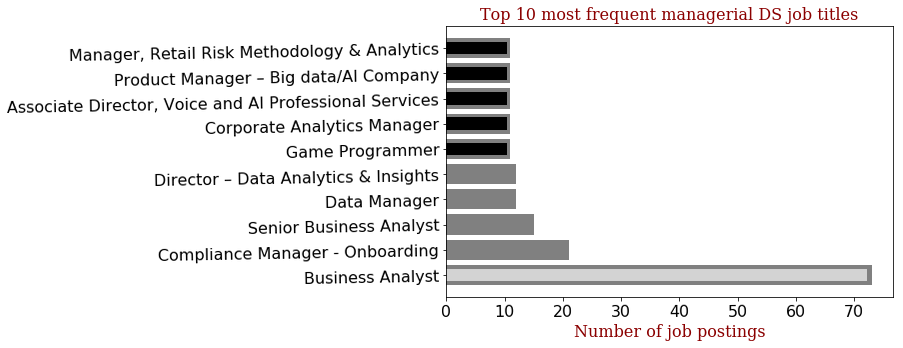

In [11]:
series_to_plot = mng_results_df['job_title'].value_counts().iloc[:10]
title = 'Top 10 most frequent managerial DS job titles'
xlabel = 'Number of job postings'
plot_bars_with_minmax(series_to_plot, title, horizontal=True, with_mean=False, xlabel=xlabel)

#### Technical roles

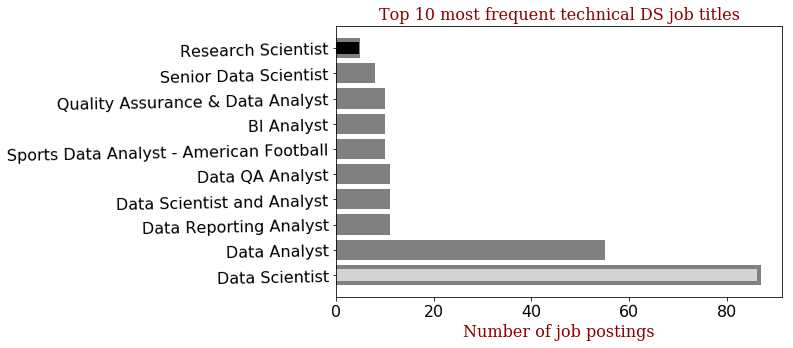

In [12]:
series_to_plot = tech_results_df['job_title'].value_counts().iloc[:10]
title = 'Top 10 most frequent technical DS job titles'
xlabel = 'Number of job postings'
plot_bars_with_minmax(series_to_plot, title, horizontal=True, with_mean=False, xlabel=xlabel)

### Job locations

#### Managerial roles

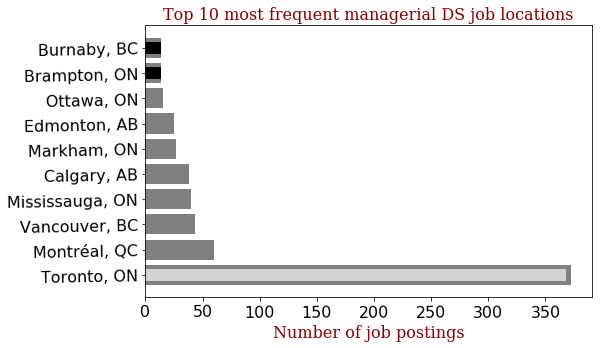

In [72]:
series_to_plot = mng_results_df['job_location'].value_counts().iloc[:10]
title = 'Top 10 most frequent managerial DS job locations'
xlabel = 'Number of job postings'
plot_bars_with_minmax(series_to_plot, title, horizontal=True, with_mean=False, xlabel=xlabel)

#### Technical roles

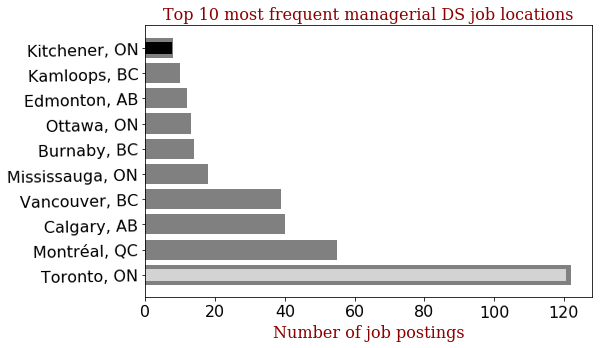

In [73]:
series_to_plot = tech_results_df['job_location'].value_counts().iloc[:10]
title = 'Top 10 most frequent managerial DS job locations'
xlabel = 'Number of job postings'
plot_bars_with_minmax(series_to_plot, title, horizontal=True, with_mean=False, xlabel=xlabel)

### Totals

#### Managerial roles

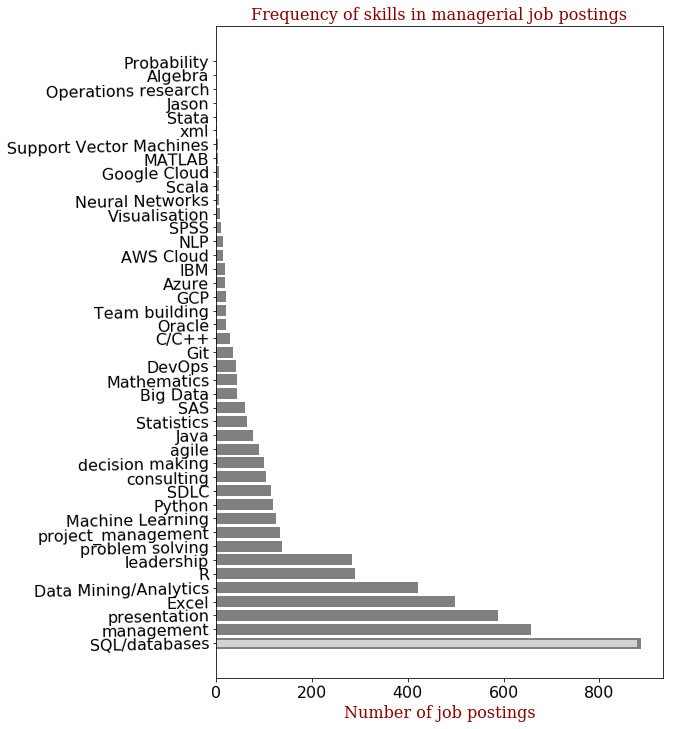

In [74]:
series_to_plot = mng_results_df.iloc[:, 5:].sum().sort_values(ascending=False)
ylabel = "No of job postings"
title = "Frequency of skills in managerial job postings"
plot_bars_with_minmax(series_to_plot, title, horizontal=True, with_mean=False, xlabel=xlabel, fig_height=12)

#### Technical roles

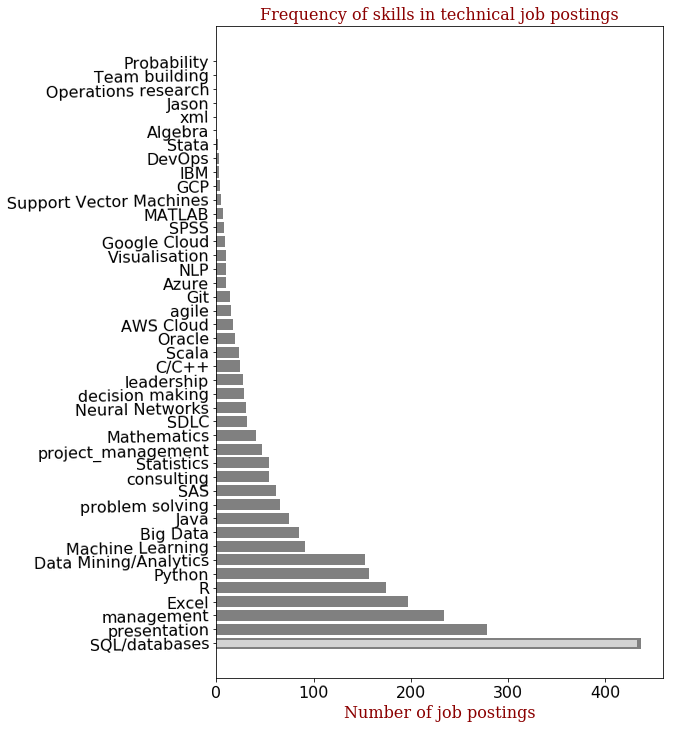

In [75]:
series_to_plot = tech_results_df.iloc[:, 5:].sum().sort_values(ascending=False)
ylabel = "No of job postings"
title = "Frequency of skills in technical job postings"
plot_bars_with_minmax(series_to_plot, title, horizontal=True, with_mean=False, xlabel=xlabel, fig_height=12)

## Saving results to a .csv file

In [76]:
mng_results_df.to_csv('ds_managerial_skills.csv')
print("Results have been saved to file 'ds_managerial_skills.csv'!")

Results have been saved to file 'ds_managerial_skills.csv'!


In [77]:
tech_results_df.to_csv('ds_tech_skills.csv')
print("Results have been saved to file 'ds_tech_skills.csv'!")

Results have been saved to file 'ds_tech_skills.csv'!
